In [1]:
!which pip

/ext3/miniforge3/envs/blind_localization/bin/pip


In [2]:
import matplotlib
from sklearn.model_selection import train_test_split
from blind_localization.data.datasets import *
from blind_localization.models.contrastive import *
from blind_localization.models.contrastive_pipeline import *
from blind_localization.models.decoder import *
from blind_localization.visualize import *
from tqdm import tqdm
import wandb
import pickle

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sweep_config = {
        'fc_layer_size': 512,
        'decoder_layer_size': 128,
        'encoder_epochs': 50,
        'decoder_epochs': 20,
        'patience': 5,
        'latent_size': 128,
        'spectrogram_size': 500,
        'encoder_learning_rate': 8e-5,
        'decoder_learning_rate': 5e-5,
        'batch_size': 64,
        'temperature': 0.606,
        'time_bins': 16,
        'library': 'pytorch'
    }

folder_path = "/scratch/th3129/region_decoding/results"
session_config = {
    "separate": True,
    "visualize": True,
    'swr_flag': False,
    't_starts': np.arange(2160, 2340, 3),
    'within_session': True,
    'supervised_contrastive': False,
    'sampling_rate': 20000,
    'trial_length': 3,
    'session_idx': True
}

In [4]:
sessions = ['AD_HF01_1']
i = 0

### 1. Check Data Preprocessing

In [5]:
def preprocess_data_new(sessions, session_config):
    features, labels, trials = {}, {}, {}
    for source_session in sessions:
        T = session_config['t_starts'][-1] - session_config['t_starts'][0] + (session_config['t_starts'][1] -  session_config['t_starts'][0])
        print(f"Session length: {T} sec")

        raw_signal, channel_labels, swr_timestamp = load_signal_labels(source_session, session_config['sampling_rate'], T)
        n_trials, n_labels, n_features = len(session_config['t_starts']), np.sum(channel_labels != 5), int(session_config['sampling_rate']*session_config['trial_length'])
        channel_features_ls = np.zeros((n_trials, n_labels, n_features))
        
        for i, t_start in enumerate(session_config['t_starts']):
            channel_features = compute_trial(raw_signal, sr=session_config['sampling_rate'], dT=session_config['trial_length'], ts=t_start)
            channel_features_ls[i] = channel_features[channel_labels != 5]
        
        channel_features_ls = channel_features_ls.reshape(-1, n_features)
        features[source_session] = channel_features_ls
        labels[source_session] = np.tile(channel_labels[channel_labels != 5], n_trials)
        trials[source_session] = np.repeat(np.arange(len(session_config['t_starts'])), n_labels)
    
    return features, labels, trials

In [21]:
def load_preprocessed_data(pickle_path, file_path):
    features, labels, trials = {}, {}, {}
    for session in file_path:
        data = pickle.load(open(f"{pickle_path}/{session}_raw.pickle", 'rb'))
        X, y, trial_idx = zip(*[(d[0], d[1], d[2]) for d in data])
        features[session] = np.array(X)
        labels[session] = np.array(y, dtype=int)
        trials[session] = np.array(trial_idx)

        non_zero_indices = [i for i, x in enumerate(features[session]) if not np.all(x == 0)]

        features[session] = features[session][non_zero_indices]
        labels[session] = labels[session][non_zero_indices]
        trials[session] = trials[session][non_zero_indices]

        # Sanity check
        assert len(features[session]) == len(labels[session]) == len(trials[session]), \
            f"Inconsistent data sizes for session {session}"

    return features, labels, trials

In [6]:
channel_features_all, channel_labels_all, channel_trials_all = preprocess_data_new(sessions, session_config)

Session length: 180 sec


100%|██████████| 1024/1024 [00:18<00:00, 55.77it/s]


In [23]:
pickle_path = '/scratch/cl7201/shared/Neuronexus/spectrogram'
channel_features_all_new, channel_labels_all_new, channel_trials_all_new = load_preprocessed_data(pickle_path, sessions)

In [30]:
(channel_features_all['AD_HF01_1'] - channel_features_all_new['AD_HF01_1']).sum()

0.0

In [32]:
(channel_labels_all['AD_HF01_1'] - channel_labels_all_new['AD_HF01_1']).sum()

0

### 2. Check train/test split and Dataloader

In [7]:
def build_single_session_dataloader(channel_features_all, channel_labels_all, session_config, sweep_config, Dataset, sessions, session_idx=0):
    idx_train, idx_test = train_test_split(range(len(session_config['t_starts'])), test_size=0.2, random_state=42)
    idx_train, idx_val = train_test_split(idx_train, test_size=0.25, random_state=42)
    indices = idx_train, idx_val, idx_test

    session_name = sessions[session_idx]
    channel_features_selected = channel_features_all[session_name].reshape((60, -1, 60000))
    channel_labels_selected = channel_labels_all[session_name].reshape((60, -1))[0]

    X_train, y_train = channel_features_selected[idx_train], channel_labels_selected
    X_val, y_val = channel_features_selected[idx_val], channel_labels_selected
    X_test, y_test = channel_features_selected[idx_test], channel_labels_selected
    
    print(X_train.shape, y_train.shape)
    print(X_train, y_train)

    train_dataset = Dataset(X_train, y_train, sampling_rate=session_config['sampling_rate'])
    val_dataset = Dataset(X_val, y_val, sampling_rate=session_config['sampling_rate'])
    test_dataset = Dataset(X_test, y_test, sampling_rate=session_config['sampling_rate'])

    train_dataloader = DataLoader(train_dataset, batch_size=sweep_config["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=sweep_config["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=sweep_config["batch_size"], shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader

In [10]:
def build_single_session_dataloader_new(channel_features_all, channel_labels_all, channel_trials_all,
                                        config, Dataset, sessions, session_idx=0):
    features = channel_features_all.get(sessions[session_idx])
    labels = channel_labels_all.get(sessions[session_idx])
    trials = channel_trials_all.get(sessions[session_idx])

    trial_length = 60
    train_tr_idx, test_tr_idx = train_test_split(range(trial_length), test_size=0.2, random_state=42)
    train_tr_idx, val_tr_idx = train_test_split(train_tr_idx, test_size=0.25, random_state=42)

    train_idx = sorted([idx for idx, val in enumerate(trials) if val in train_tr_idx], key=lambda idx: train_tr_idx.index(trials[idx]))
    val_idx = sorted([idx for idx, val in enumerate(trials) if val in val_tr_idx], key=lambda idx: val_tr_idx.index(trials[idx]))
    test_idx = sorted([idx for idx, val in enumerate(trials) if val in test_tr_idx], key=lambda idx: test_tr_idx.index(trials[idx]))

    X_train, y_train = features[train_idx], labels[train_idx]
    X_val, y_val = features[val_idx], labels[val_idx]
    X_test, y_test = features[test_idx], labels[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_train, y_train)

    train_dataset = Dataset(np.array(X_train), y_train, spectrogram_size=500,
                            time_bins=config["time_bins"], library=config["library"])
    val_dataset = Dataset(np.array(X_val), y_val, spectrogram_size=500,
                          time_bins=config["time_bins"], library=config["library"])
    test_dataset = Dataset(np.array(X_test), y_test, spectrogram_size=500,
                           time_bins=config["time_bins"], library=config["library"])

    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader

### 3. Check Dataset

In [8]:
class OriginalDataset(Dataset):
    def __init__(self, raw_signal, labels, sampling_rate=20000, n_fft=2048, n_freq_bins = 500, n_time_bins=16, transform=None, session_labels=None):
        self.raw_signal = torch.tensor(raw_signal, dtype=torch.float32)
        self.labels = torch.tensor(labels)
        self.n_time_bins = n_time_bins
        self.n_trials, self.n_channels, self.n_features = raw_signal.shape
        self.n_freq_bins, self.n_fft = n_freq_bins, n_fft

        self.hop_length = self.n_features // (self.n_time_bins - 1)
        self.spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=self.n_fft, win_length=self.n_fft, hop_length=self.hop_length, power=2.0)
        self.transform = transform
        self.session_labels = session_labels
        self.return_session_trial = True if session_labels is not None else False
        print("n_freq_bins, n_fft, hop_length: ", self.n_freq_bins, self.n_fft, self.hop_length)

        # precompute spectrograms and augmented spectrograms to save time during training and inference
        self.spectrograms, self.augmented_spectrograms = self._compute_spectrogram(self.raw_signal)
        print("spectrogram of size: ", (self.n_freq_bins, self.n_time_bins))
        print(self.spectrograms[0][0])
        self.visualize_spectrograms(self.spectrograms, self.augmented_spectrograms)

    def _compute_spectrogram(self, raw_signal):
        spectrograms = torch.zeros((self.n_trials, self.n_channels, self.n_freq_bins*self.n_time_bins))
        augmented_spectrograms = torch.zeros((self.n_trials, self.n_channels, self.n_freq_bins*self.n_time_bins))

        for trial_idx in range(self.n_trials):
            for channel_idx in range(self.n_channels):
                data = raw_signal[trial_idx][channel_idx]
                spectrogram = 10 * torch.log10(self.spectrogram_transform(data)[:self.n_freq_bins])
                # spectrogram = zscore(spectrogram, axis=0)
                spectrograms[trial_idx][channel_idx] = spectrogram.flatten()
                augmented_spectrogram = self.temporal_masking(spectrogram)
                augmented_spectrograms[trial_idx][channel_idx] = augmented_spectrogram.flatten()

        return spectrograms, augmented_spectrograms
    
    def temporal_masking(self, spectrogram, percent_masked=0.2, mask_size=1):
        n_masks = int(spectrogram.size(1) * percent_masked)
        
        for _ in range(n_masks):
            start_idx = torch.randint(0, spectrogram.size(1) - mask_size, (1,)).item()
            spectrogram[:, start_idx:start_idx+mask_size] = 0

        return spectrogram
    
    def __len__(self):
        return self.n_trials * self.n_channels
    
    def __getitem__(self, index):
        trial_idx = index // self.n_channels
        channel_idx = index % self.n_channels

        spectrograms = self.spectrograms[trial_idx][channel_idx]
        augmented_spectrograms = self.augmented_spectrograms[trial_idx][channel_idx]

        label = self.labels[channel_idx]

        if self.return_session_trial:
            session_label = self.session_labels[trial_idx]
            return (spectrograms, augmented_spectrograms), label, (session_label, trial_idx)

        return (spectrograms, augmented_spectrograms), label

    def visualize_spectrograms(self, spectrograms, augmented_spectrograms):
        # Function to save spectrogram
        def save_spectrogram(spectrogram_data, suffix):
            spectrogram = spectrogram_data[0][0].reshape((self.n_freq_bins, self.n_time_bins))
            frequencies = np.arange(0, 500)

            time_steps = np.linspace(0, 3, 16)

            plt.figure(figsize=(6, 6))
            plt.pcolormesh(time_steps, frequencies, spectrogram, shading='gouraud')
            plt.ylim(0, 500)
            plt.colorbar(label='Intensity [dB]')
            plt.xlabel('Time [s]')
            plt.ylabel('Frequency [Hz]')
            plt.title(f'{suffix} Spectrogram - Normal Scale')
            plt.tight_layout()
            plt.show()

        # Save normal spectrogram
        save_spectrogram(spectrograms, 'normal')

        # Save Mel spectrogram
        save_spectrogram(augmented_spectrograms, 'augmented')

In [9]:
class RawDataset(Dataset):
    def __init__(self, raw_signal, labels, nperseg=2048, spectrogram_size=500, transform=None, library='pytorch',
                 time_bins=None):
        self.raw_signal = torch.tensor(raw_signal, dtype=torch.float32)
        self.labels = torch.tensor(labels)
        self.library = library
        self.sample_rate = 1250  # Make sure to change this according to the sampling rate of the data
        self.n_channels, self.n_features = raw_signal.shape

        # Calculate hop_length based on the desired number of time_bins
        self.time_bins = time_bins
        if library == 'scipy':
            self.time_bins = 2 * self.time_bins + 2

        self.nperseg = nperseg
        self.hop_length = self.n_features // (self.time_bins - 1)
        self.spectrogram_size = spectrogram_size
        self.transform = transform
        print("nperseg, hop_length, n_channels, n_features: ", self.nperseg, self.hop_length, self.n_channels, self.n_features)

        # Precompute spectrograms and augmented spectrograms to save time during training and inference
        self.spectrograms, self.augmented_spectrograms = self._compute_spectrogram(self.raw_signal,
                                                                                   spectrogram_size, self.time_bins)
        print(self.spectrograms[0])
        self.visualize_spectrograms(self.spectrograms, self.augmented_spectrograms)

    def _compute_spectrogram(self, raw_signal, spectrogram_size, timebins):
        spectrograms = torch.zeros((self.n_channels, spectrogram_size * timebins))
        augmented_spectrograms = torch.zeros((self.n_channels, spectrogram_size * timebins))

        for channel_idx in range(self.n_channels):
            data = raw_signal[channel_idx]
            if self.library is None or self.library == 'pytorch':
                spectrogram = self._pytorch_spectrogram(data)
            elif self.library == 'librosa':
                spectrogram = self._librosa_spectrogram(data)
            elif self.library == 'scipy':
                spectrogram = self._scipy_spectrogram(data)
            ##### modified
            spectrogram = spectrogram[:spectrogram_size]
            # spectrogram = zscore(spectrogram, axis=0)
            spectrogram = torch.tensor(spectrogram, dtype=torch.float32)

            spectrograms[channel_idx] = spectrogram.flatten()

            augmented_spectrogram = self.temporal_masking(spectrogram)
            augmented_spectrograms[channel_idx] = augmented_spectrogram.flatten()

        return spectrograms, augmented_spectrograms

    def _pytorch_spectrogram(self, data):
        # Use the torchaudio library for spectrogram computation
        spectrogram_transform = torchaudio.transforms.Spectrogram(
            n_fft=self.nperseg, win_length=self.nperseg, hop_length=self.hop_length, power=2.0
        )
        return 10 * torch.log10(spectrogram_transform(data))

    def _librosa_spectrogram(self, data):
        # Use librosa for spectrogram computation
        spectrogram = librosa.stft(data.numpy(), n_fft=self.nperseg, hop_length=self.hop_length,
                                   win_length=self.nperseg)
        spectrogram = np.abs(spectrogram) ** 2
        epsilon = 1e-10
        spectrogram = 10 * np.log10(spectrogram + epsilon)
        ## update librosa computation as numpy output
        # spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
        return spectrogram

    def _scipy_spectrogram(self, data):
        # Use scipy for spectrogram computation
        frequencies, times, spectrogram = scipy.signal.spectrogram(data.numpy(), nperseg=self.nperseg,
                                                                   noverlap=self.nperseg - self.hop_length)
        return torch.tensor(spectrogram, dtype=torch.float32)

    def temporal_masking(self, spectrogram, percent_masked=0.25, mask_size=1):
        n_masks = int(spectrogram.size(1) * percent_masked)

        for _ in range(n_masks):
            start_idx = torch.randint(0, spectrogram.size(1), (1,)).item()
            spectrogram[:, start_idx:start_idx + mask_size] = 0

        return spectrogram

    def frequency_masking(self, spectrogram, percent_masked=0.05, mask_size=5):
        n_masks = int(spectrogram.size(0) * percent_masked)

        for _ in range(n_masks):
            start_idx = torch.randint(0, spectrogram.size(0) - mask_size, (1,)).item()
            spectrogram[start_idx:start_idx + mask_size, :] = 0

        return spectrogram

    def __len__(self):
        return self.n_channels

    def add_gaussian_noise(self, signal):
        return signal + torch.randn_like(signal) * 0.01

    def __getitem__(self, index):
        channel_idx = index % self.n_channels

        spectrograms = self.spectrograms[channel_idx]
        augmented_spectrograms = self.augmented_spectrograms[channel_idx]

        label = self.labels[channel_idx]

        return (spectrograms, augmented_spectrograms), label

    def visualize_spectrograms(self, spectrograms, augmented_spectrograms):
        # Function to save spectrogram
        def save_spectrogram(spectrogram_data, suffix):
            spectrogram = spectrogram_data[0].reshape((self.spectrogram_size, self.time_bins))
            frequencies = np.arange(0, 500)

            time_steps = np.linspace(0, 3, 16)

            plt.figure(figsize=(6, 6))
            plt.pcolormesh(time_steps, frequencies, spectrogram, shading='gouraud')
            plt.ylim(0, 500)
            plt.colorbar(label='Intensity [dB]')
            plt.xlabel('Time [s]')
            plt.ylabel('Frequency [Hz]')
            plt.title(f'{suffix} Spectrogram - Normal Scale')
            plt.tight_layout()
            plt.show()
            plt.savefig(f'../results/{suffix}_spectrogram_normal.png')

        # Save normal spectrogram
        save_spectrogram(spectrograms, 'normal')

        # Save Mel spectrogram
        save_spectrogram(augmented_spectrograms, 'augmented')


(36, 647, 60000) (647,)
[[[-1.17122471 -1.14042568 -1.14042568 ... -2.47247982 -2.50135398
   -2.4436059 ]
  [-1.00809932 -1.03498614 -1.06187308 ... -2.03159285 -2.38291478
   -2.4904623 ]
  [-1.00222707 -1.03046393 -1.00222707 ... -3.40612507 -3.15199327
   -2.30300498]
  ...
  [ 0.75721681  0.60054749  0.60054749 ...  0.70499372  0.75721681
    0.75721681]
  [ 0.93817288  1.05190182  1.05190182 ...  0.824444    0.88130844
    0.88130844]
  [ 0.40713161  0.51571912  0.62430668 ...  1.00436306  1.00436306
    1.00436306]]

 [[-2.73234606 -2.73234606 -2.67459798 ... -1.31559467 -1.28672075
   -1.28672075]
  [-2.54423594 -2.57112288 -2.62489653 ... -1.17121303 -1.11743927
   -1.14432609]
  [-2.64372993 -2.70020342 -2.64372993 ... -0.9739902  -0.8892796
   -0.91751647]
  ...
  [ 0.49610123  0.49610123  0.44387811 ...  1.38389421  1.4883405
    1.43611741]
  [ 0.59698617  0.59698617  0.59698617 ...  1.1656307   1.1656307
    1.22249508]
  [ 0.57001293  0.46142539  0.51571912 ...  0.841481

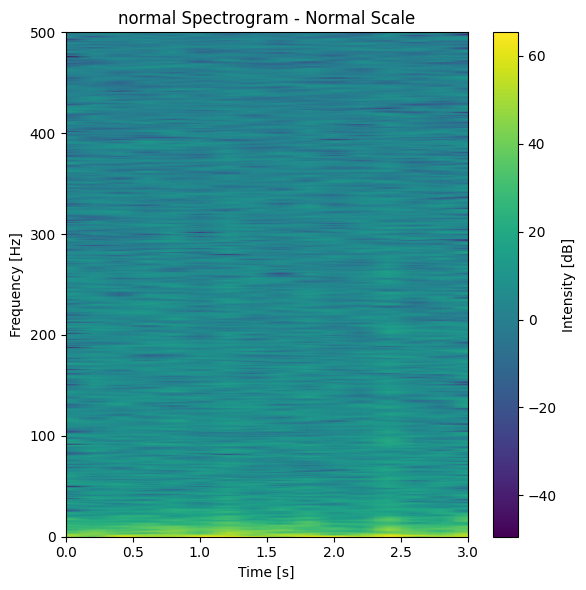

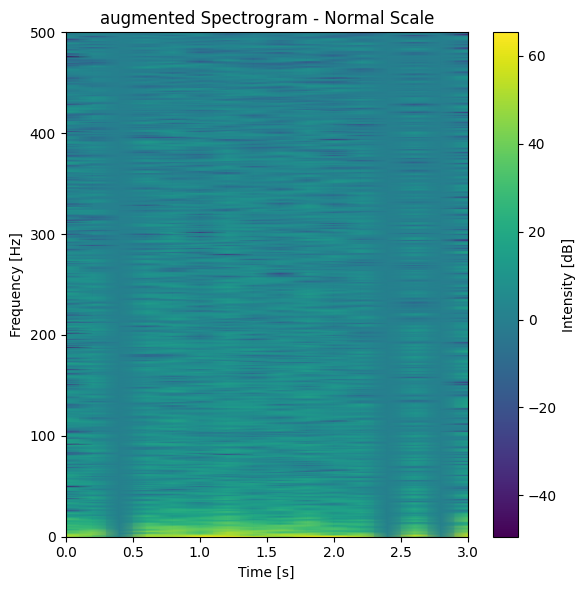

n_freq_bins, n_fft, hop_length:  500 2048 4000
spectrogram of size:  (500, 16)
tensor([42.7047, 49.6404, 55.5826,  ..., -0.4476,  1.5054,  6.8680])


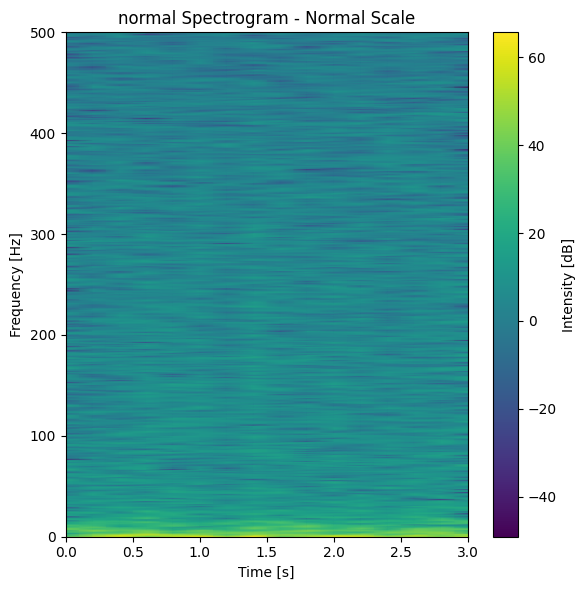

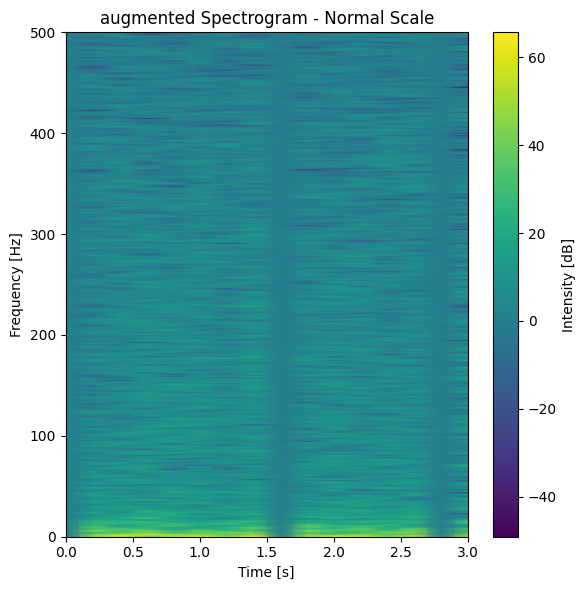

n_freq_bins, n_fft, hop_length:  500 2048 4000
spectrogram of size:  (500, 16)
tensor([57.0425, 51.5889, 60.7809,  ..., -3.1926, -2.4978,  1.6418])


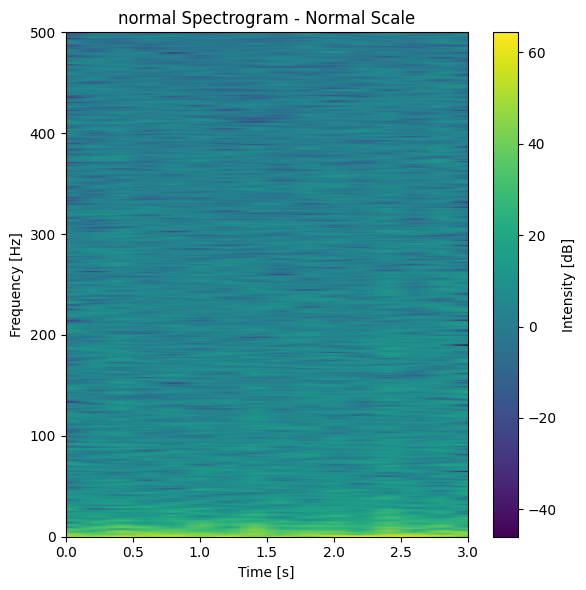

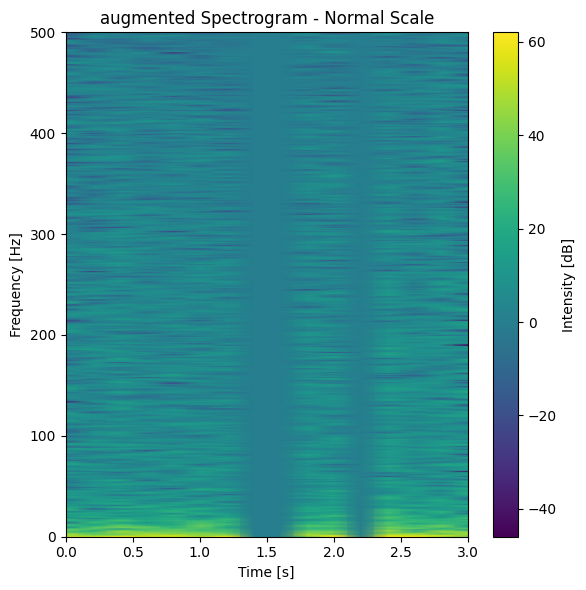

In [11]:
train_dataloader, val_dataloader, test_dataloader = build_single_session_dataloader(channel_features_all,
                                                                                    channel_labels_all,
                                                                                    session_config,
                                                                                    sweep_config,
                                                                                    OriginalDataset, sessions,
                                                                                    session_idx=i)

(23292, 60000) (23292,)
[[-1.17122471 -1.14042568 -1.14042568 ... -2.47247982 -2.50135398
  -2.4436059 ]
 [-1.00809932 -1.03498614 -1.06187308 ... -2.03159285 -2.38291478
  -2.4904623 ]
 [-1.00222707 -1.03046393 -1.00222707 ... -3.40612507 -3.15199327
  -2.30300498]
 ...
 [-0.07835311 -0.07835311 -0.13057624 ...  2.06279492  2.01057172
   1.95834863]
 [-0.19911602 -0.19911602  0.02834176 ...  1.84800398  2.01859736
   2.07546186]
 [ 0.08136903  0.13566279  0.13566279 ...  2.52820826  2.47391438
   2.52820826]] [4 4 4 ... 0 0 0]
nperseg, hop_length, n_channels, n_features:  2048 4000 23292 60000


/state/partition1/job-54244423/ipykernel_1318406/4293969858.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram = torch.tensor(spectrogram, dtype=torch.float32)


tensor([46.7661, 44.7562, 59.8792,  ...,  1.9213,  4.7483, -9.1079])


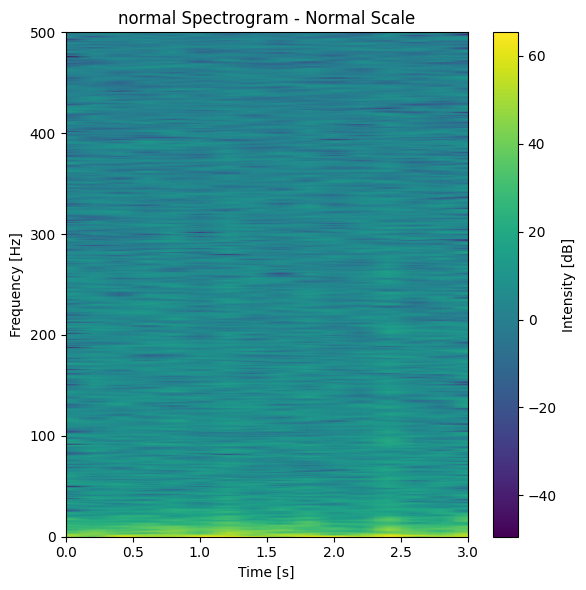

<Figure size 640x480 with 0 Axes>

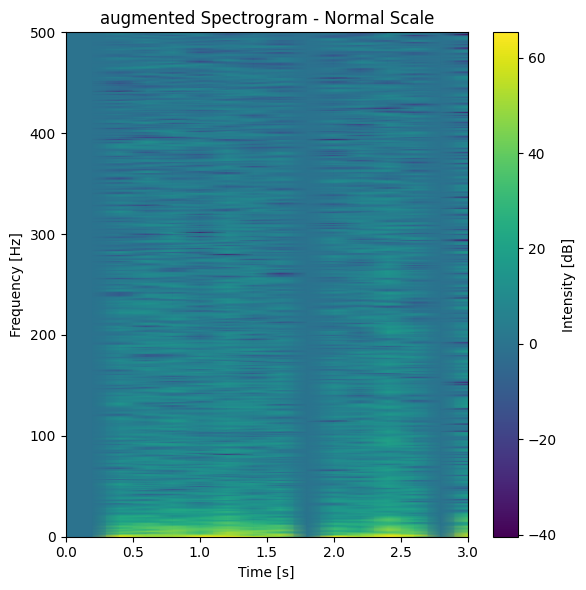

nperseg, hop_length, n_channels, n_features:  2048 4000 7764 60000
tensor([42.7047, 49.6404, 55.5826,  ..., -0.4476,  1.5054,  6.8680])


<Figure size 640x480 with 0 Axes>

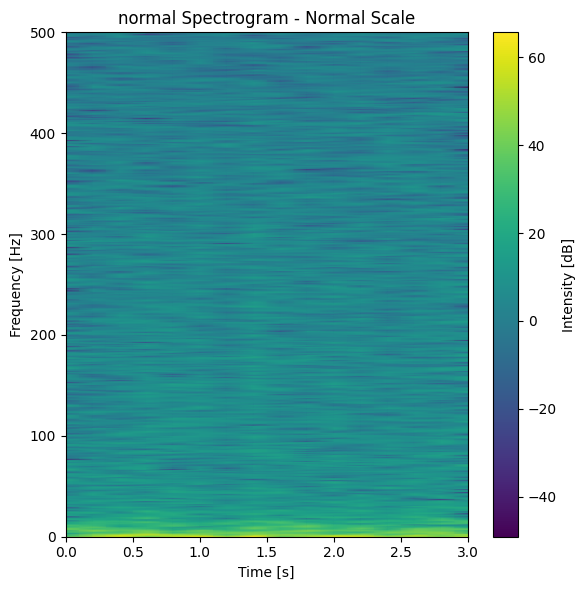

<Figure size 640x480 with 0 Axes>

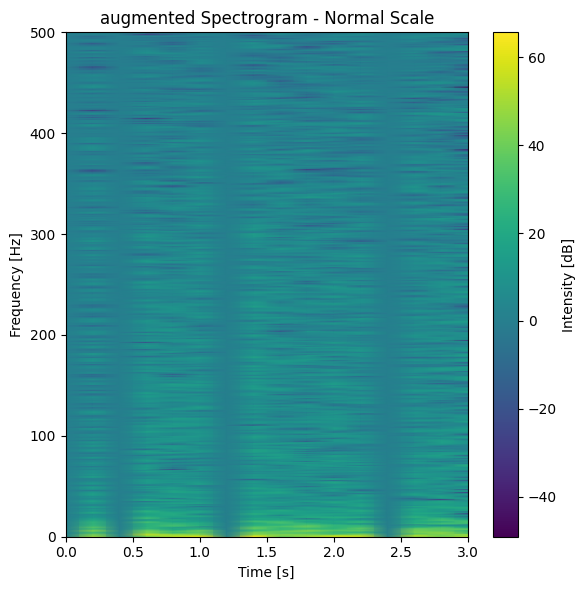

nperseg, hop_length, n_channels, n_features:  2048 4000 7764 60000
tensor([57.0425, 51.5889, 60.7809,  ..., -3.1926, -2.4978,  1.6418])


<Figure size 640x480 with 0 Axes>

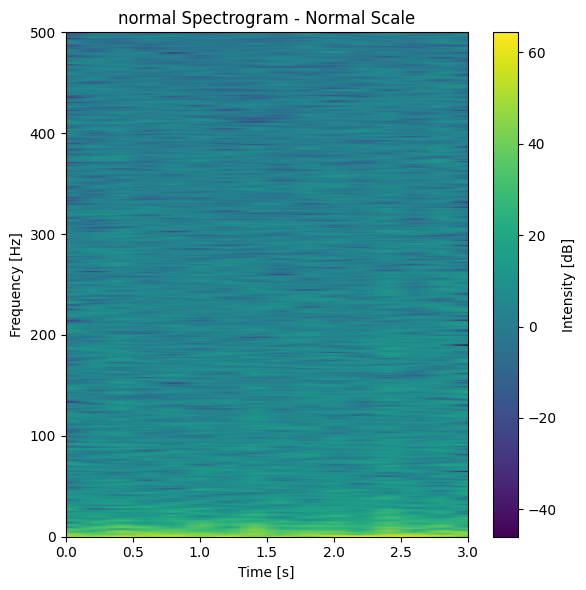

<Figure size 640x480 with 0 Axes>

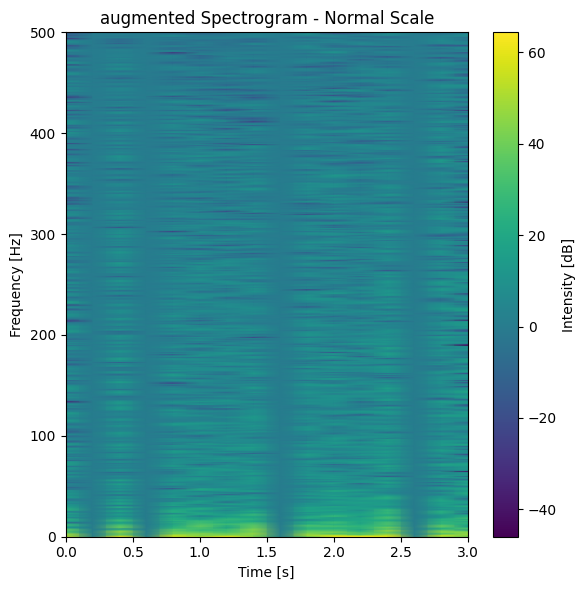

<Figure size 640x480 with 0 Axes>

In [13]:
train_dataloader_new, val_dataloader_new, test_dataloader_new = build_single_session_dataloader_new(channel_features_all,
                                                                                                    channel_labels_all,
                                                                                                    channel_trials_all,
                                                                                                    sweep_config,
                                                                                                    RawDataset, sessions,
                                                                                                    session_idx=i)

In [18]:
# evaluate if the previous code give the same output as current code
train_dataset = train_dataloader.dataset
train_dataset_new = train_dataloader_new.dataset

for i in range(len(train_dataset)):
    img = (train_dataset[i][0][0].eq(train_dataset_new[i][0][0])).all()
    label = (train_dataset[i][1].eq(train_dataset_new[i][1])).all()
    if not img or not label:
        print(i)

In [20]:
print("old dataset", train_dataloader.dataset[0])
print("new dataset", train_dataloader_new.dataset[0])

old dataset ((tensor([46.7661, 44.7562, 59.8792,  ...,  1.9213,  4.7483, -9.1079]), tensor([46.7661, 44.7562,  0.0000,  ...,  1.9213,  0.0000, -9.1079])), tensor(4))
new dataset ((tensor([46.7661, 44.7562, 59.8792,  ...,  1.9213,  4.7483, -9.1079]), tensor([ 0.0000,  0.0000, 59.8792,  ...,  1.9213,  0.0000, -9.1079])), tensor(4))
